# Home Credit Default Risk Exporatory Data Analysis


#  このEDAの目的
- 個人のデフォルトリスクを推定する信用スコアリングモデルは個人融資を行う際の与信業務に極めて有用
- 与信コストを下げることが必要。まだまだお金を貸せるカスタマーの母数は多く、より簡単にお金を借りていただけるようにSpeedyに与信をしていきたい
- 与えられたデータを用いて、いくつかの機械学習手法によりスコアリングモデルを構築し、どのような手法が高い精度を出せるのかを調べる
- （個人課題）EDA ではないかもしれないが、いくつか学習モデルを構築まではしておいて、分類問題をエンドツーエンドで説明できるイメージを持ちたい

# 活動方針
- 一般的には、信用スコアリングモデルはLogistic Regression(のような統計的な手法が用いられてきたようである。金融機関は実務の信用スコアリングモデルを公表しないため、具体的にどういった手法が多く使われているかは不明であるが、Logistic Regression、もしくはLogistic RegressionとDecision Treeを組み合わせたハイブリッドモデルが多いと考えられる。
- 近年は様々な機械学習の手法が提案されており、著しく精度が向上している。いくつか機械学習手法によりスコアリングモデルを構築し、どのような手法が高い精度を出せるのかを調べる



# 機械学習モデル
- Logistics Regression
- Support Vector machine
- Gradient Boosting Classifier (GBC)
- （のちにやります）XGBoost（XGB）
- （のちにやります）Neural Network (NN)


ベンチマークとして Logistic Regression によるモデルを使用し、７月２８日時点では他Support Vector MachineとGrandient Boosting Classifireを含め３つで比較を試みた。

データは、トレーニング用データが与えられている。トレーニング用データからテスト用に分割した。

各機械学習手法にはハイパーパラメータが複数存在する。最適なパラメータはデータセットによって異なるため、パラメータの最適化を行う必要がある。

先に次のことを書いておくと、のこりXGBoostとNeural Networkも用いて出し、その後アンサンブル学習にも挑戦したい。学習は融資実行後にデフォルトしたかどう　かを示すフラグ（1 - client with payment difficulties、0 -  それ以外）゙をトレーニングデータとして学習を行う。 アンサンブル学習にはVotingを用いたい。




# 前処理サマリ
あとで前処理手続きが書かれているが、欠損値が多い事から初めに欠損値をなくす。
まず今回の方法としては、特徴量の欠損率が高いものは特徴量ごと消し、多くないものは欠損しているセルに０を代入した。
その後、ラベルエンコーディングと、ホットエンコーディングで、特徴量として計算しやすいように加工した。

一般には、特徴の中身を平均したり中央値をとったり、最頻値を取るやり方もあり、欠損値が高くても、特徴自体を殺さない方法もある。

また少し調査したところ、いくつかの機械学習モデルは、スケーリングレベル（例えば、分類木およびベイズ分類器）の混合データを扱うのに適しており、
ANNおよびSVMは質的なデータ(カテゴリー変数、categorical variable)に適しているというレポートがあった(Sven F.Cronea, Stefan Lessmann, Robert Stahlbock, : The impact of preprocessing on data mining: An evaluation of classifier sensitivity in direct marketing)。



## 必要なライブラリをImportしましょう

In [135]:
# importing modules to 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
import pandas_profiling as pdp

## テーブルの種類の把握をしましょう

Now, we can look at what's inside. Following chart shows data tables overview.
<img src="./home_credit.png">




## 見やすい様に表示を工夫しましょう

In [3]:
#長いURLや行数が多いとき省略されてしまい困った。
#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 101)

#行数
pd.set_option("display.max_rows", 200)


##  まずは対象のCSVを読み込みましょう

In [ ]:
train = pd.read_csv("./application_train.csv")
test = pd.read_csv("./application_test.csv")
bureau = pd.read_csv("./bureau.csv")
bbalance = pd.read_csv("./bureau_balance.csv")
pos = pd.read_csv("./POS_CASH_balance.csv")
insta = pd.read_csv("./installments_payments.csv")
previous = pd.read_csv("./previous_application.csv")
credit = pd.read_csv("./credit_card_balance.csv")

## Trainデータの中身を確認しましょう

In [42]:
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [266]:
test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
bureau.head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [268]:
bbalance.head(5)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [269]:
pos.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [270]:
insta.head(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [271]:
previous.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [272]:
credit.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


### Findings: 大量の特徴量、カテゴリカルデータ、欠損値

特徴の数が膨大で、数値以外のデータもあり、すでに欠損値も見つかりました。



###   判断: Trainデータだけで、TARGETという特徴をどれだけ説明できるかをまず知って見たい
以下では、まずは欠損値などを無くして（ここでは欠損値をある一定の率以上と以下に分けて欠損が多すぎる特徴を考慮しない）、One Hot Encodingを行い、全て数値のデータに変更して、機械学習モデルにかけるとしたい。

　　

##    欠損をなくす
.info()でNULLの有無やデータ型を見てみます。

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


NULL値はあっても、NANとして表示されるので、info()にはNULはなしと出てると思われる

これだとわからないので、ライブラリを使用して。

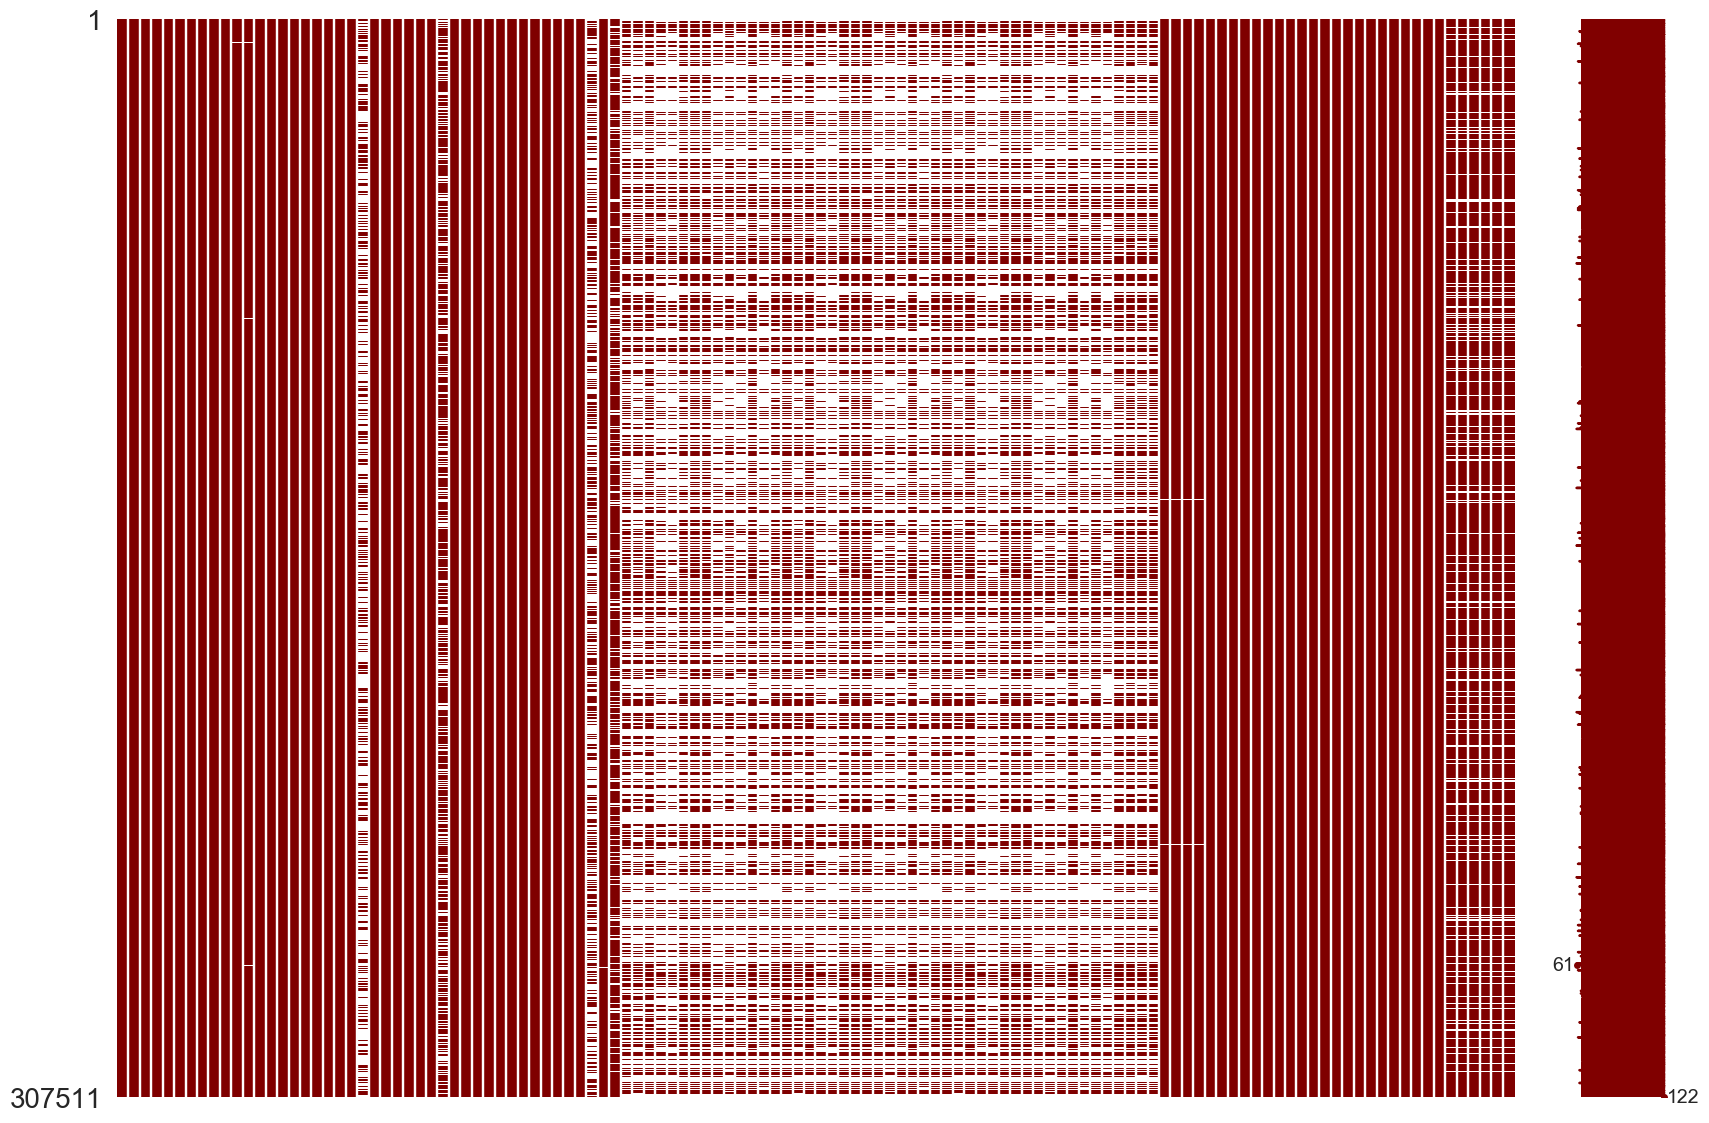

In [44]:
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

missingnoという素晴らしいライブラリの力により、マトリックスのどこにNaNがあるのか一瞬で視覚化できます。白い場所が、データが欠損している場所です。

In [46]:
print(train.isnull().sum())

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

上記の欠損値より、今回はNaNが31%以上あるものはデータフレームから落とし、それ以外はその列のNaNに0を代入することにしました。

In [47]:
# drop するcolumnをArrayへ
drop_col = ['COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI', 'OWN_CAR_AGE', 'LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'EXT_SOURCE_1', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'ELEVATORS_MEDI', 'WALLSMATERIAL_MODE', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'APARTMENTS_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE']

In [57]:
# 31%以上あるものはデータフレームから落とす

train_wo_nan = train.drop(drop_col, axis=1)




In [60]:
#  他にもまだNaNがあるが、使えそうと想定して、あえて平均などを用いずに０を代入する
train_wo_nan = train_wo_nan.fillna(0)



###   欠損がなくなったかチェックしましょう

In [62]:
train_wo_nan.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
動きが遅くなることが多いので、ここいらでCSVを分けましょう。

In [63]:
#CSV に保存

train_wo_nan.to_csv("train_wo_nan.csv")

In [51]:
train_wo_nan = pd.read_csv("./train_wo_nan.csv")

### 欠損がなくなったか目でも確認しましょう

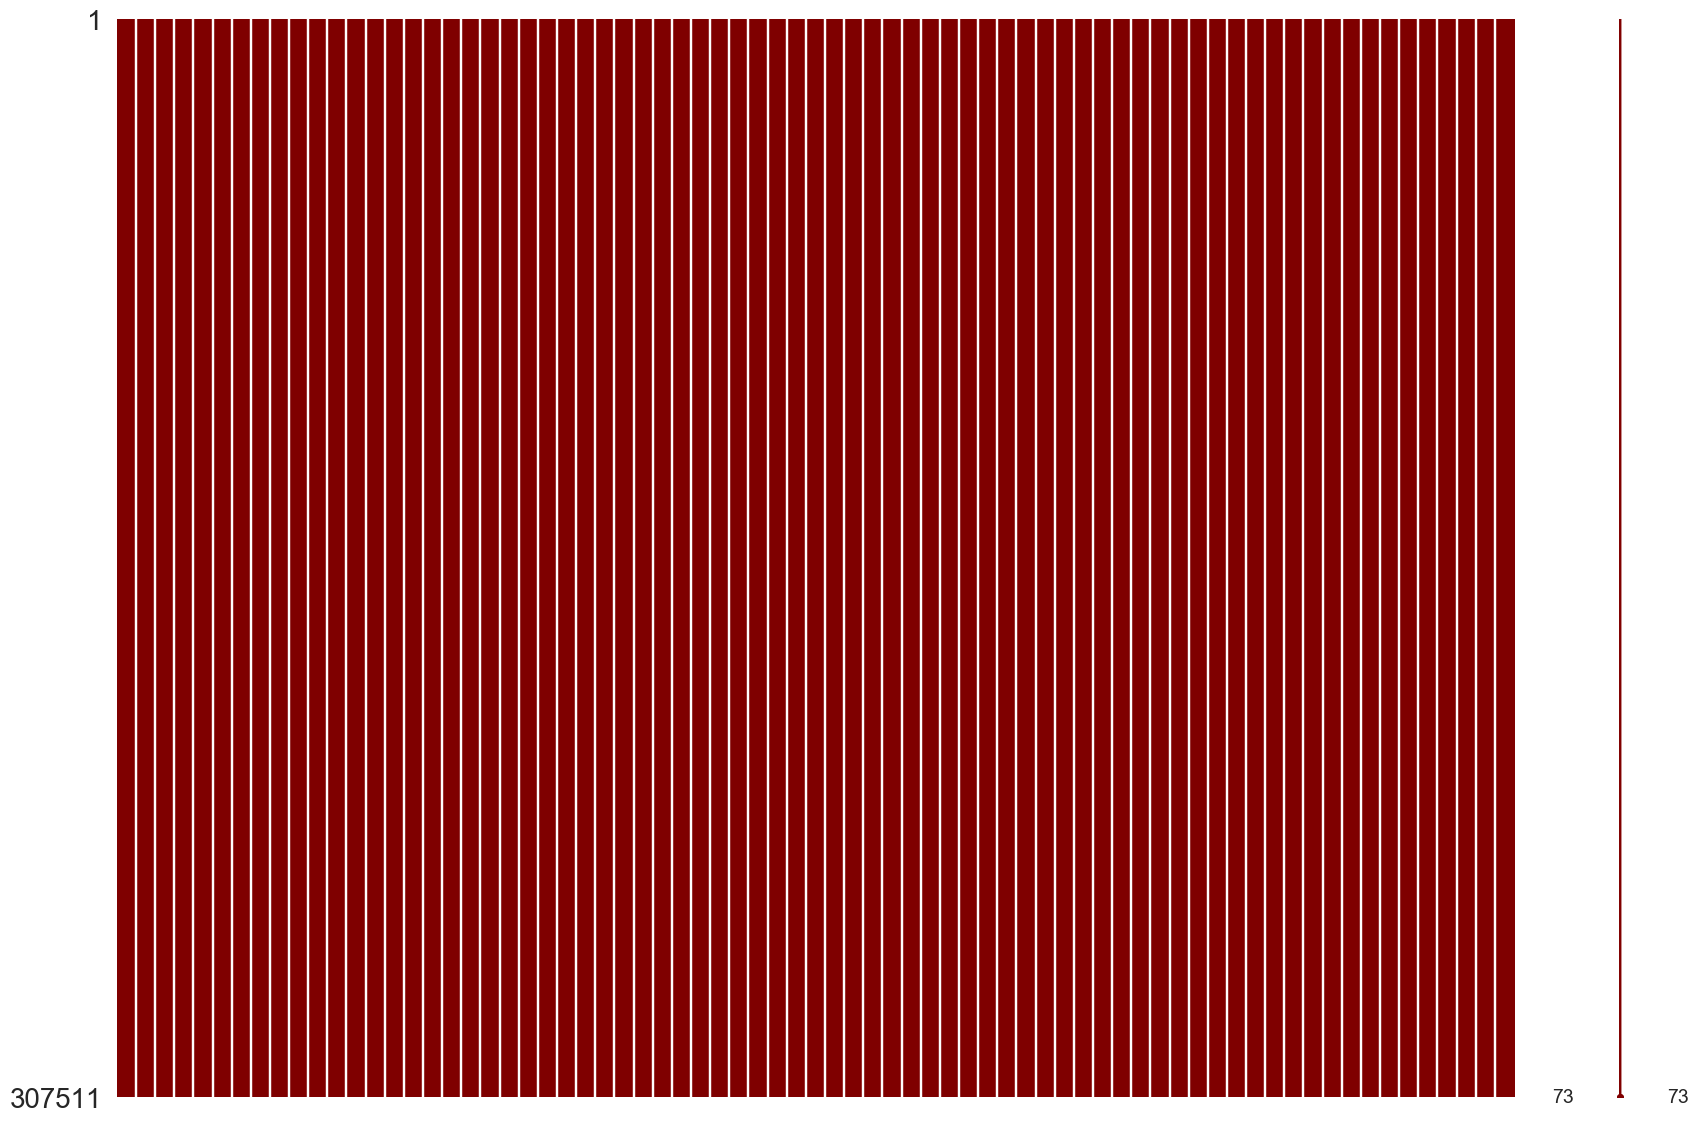

In [64]:
msno.matrix(df=train_wo_nan, figsize=(20,14), color=(0.5,0,0))

### 記述統計でもチェックしましょう

In [65]:
train_wo_nan.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27107.516051,5.379095e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.005538,0.006055,0.029723,0.231293,0.229631,1.643447
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14494.443757,3.696338e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.078014,0.103037,0.190728,0.856810,0.744059,1.855821
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,0.000000,0.000000e+00,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### データタイプを確認

In [150]:
#与えられたデータがざっくり数値なのか、それとも文章なのか、データタイプを把握しましょう。.dtypesで各列のデータタイプを取得します
print(train_wo_nan.dtypes)

SK_ID_CURR                       int64
TARGET                           int64
NAME_CONTRACT_TYPE               int64
CODE_GENDER                     object
FLAG_OWN_CAR                     int64
FLAG_OWN_REALTY                  int64
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
FLAG_MOBIL                       int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_CONT_MOBILE                 int64
FLAG_PHONE               

In [86]:
train_wo_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null int64
CODE_GENDER                    307511 non-null object
FLAG_OWN_CAR                   307511 non-null int64
FLAG_OWN_REALTY                307511 non-null int64
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307511 non-null float64
AMT_GOODS_PRICE                307511 non-null float64
NAME_TYPE_SUITE                307511 non-null object
NAME_INCOME_TYPE               307511 non-null object
NAME_EDUCATION_TYPE            307511 non-null object
NAME_FAMILY_STATUS             307511 non-null object
NAME_HOUSING_TYPE              307511 non-null object
REGION_POPULATION_RELATIVE 

##  ラベルエンコーディングとホットワンエンコーディング

In [80]:
#　カラムの中を見て２変数だったらラベルエンコーダーにして&それ以外はホットエンコーダーする構文

from sklearn import preprocessing

train_wo_nan_encoded = train_wo_nan
le = preprocessing.LabelEncoder()
for col in train_wo_nan:
   if train_wo_nan[col].dtype == "object":
       if len(list(train_wo_nan[col].unique())) <= 2:
           le.fit(train_wo_nan[col])
           
           train_wo_nan_encoded[col] = le.transform(train_wo_nan[col])
        
train_wo_nan_encoded = pd.get_dummies(train_wo_nan_encoded)
#return df_train_
train_wo_nan_encoded.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


###  エンコーディングできたかチェックしましょう

infoを取得しましょう

In [87]:
train_wo_nan_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 184 entries, SK_ID_CURR to ORGANIZATION_TYPE_XNA
dtypes: float64(20), int64(44), uint8(120)
memory usage: 185.3 MB


In [88]:
print(train_wo_nan_encoded.dtypes)

SK_ID_CURR                                             int64
TARGET                                                 int64
NAME_CONTRACT_TYPE                                     int64
FLAG_OWN_CAR                                           int64
FLAG_OWN_REALTY                                        int64
CNT_CHILDREN                                           int64
AMT_INCOME_TOTAL                                     float64
AMT_CREDIT                                           float64
AMT_ANNUITY                                          float64
AMT_GOODS_PRICE                                      float64
REGION_POPULATION_RELATIVE                           float64
DAYS_BIRTH                                             int64
DAYS_EMPLOYED                                          int64
DAYS_REGISTRATION                                    float64
DAYS_ID_PUBLISH                                        int64
FLAG_MOBIL                                             int64
FLAG_EMP_PHONE          

### 重いのでcsvを分けて保存しましょう

In [84]:
#CSV に保存

train_wo_nan_encoded.to_csv("train_wo_nan_encoded.csv")

###  相関を見て見ましょう

In [92]:
# CSV を読む

train_wo_nan_encoded = pd.read_csv("./train_wo_nan_encoded.csv")

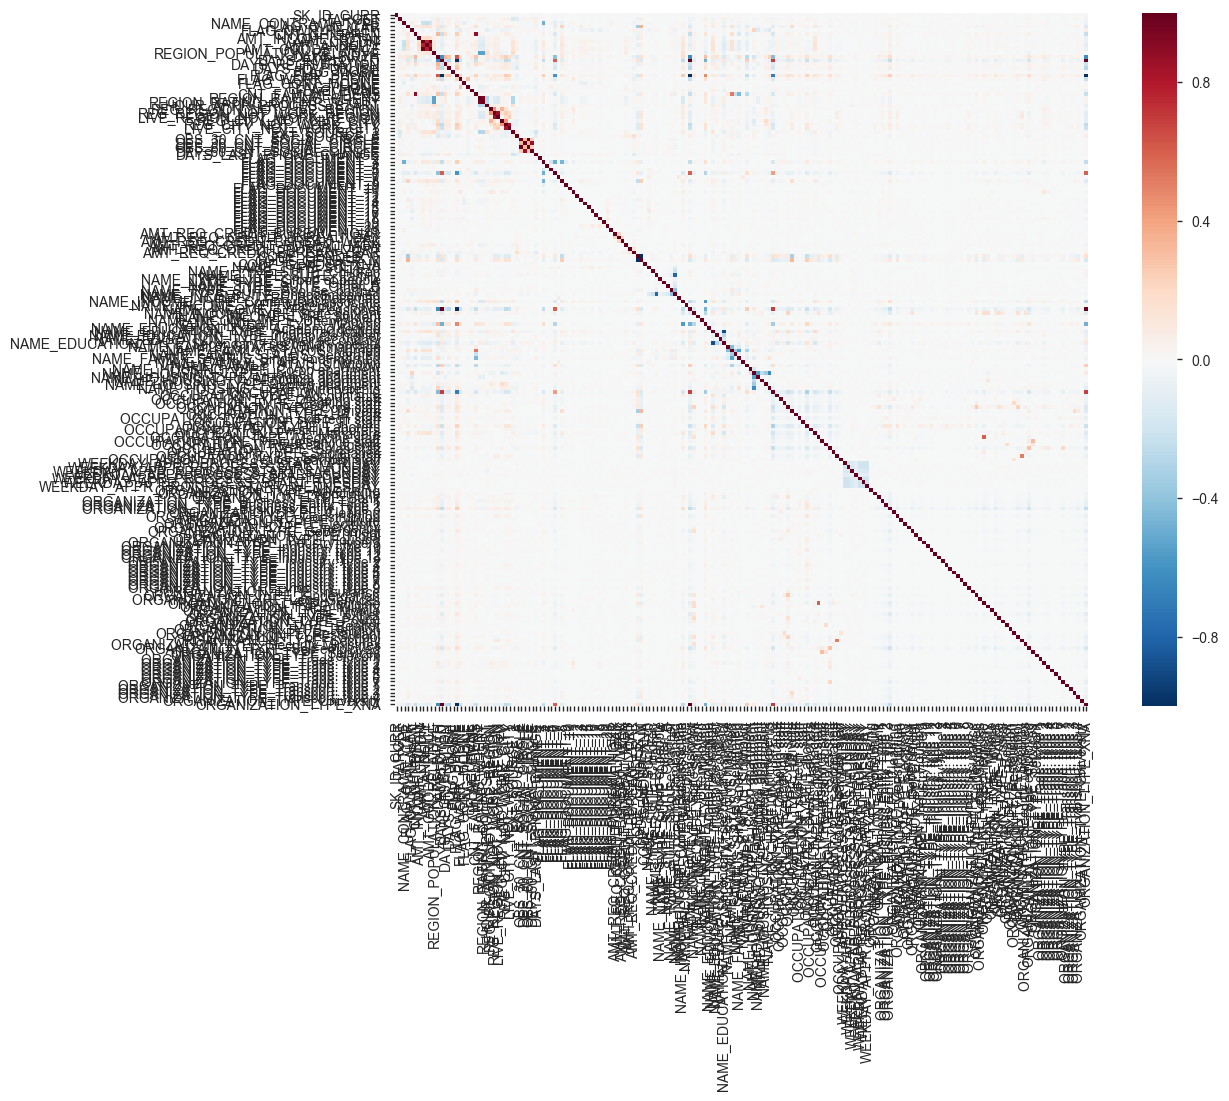

In [90]:
#Correlation Matrix
corrmat = train_wo_nan_encoded.corr()
f, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [91]:
corrmat = train_wo_nan_encoded.corr()
corrmat

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
SK_ID_CURR,1.000000,-0.002108,0.001654,0.001216,0.000703,-0.001129,-0.001820,-0.000343,-0.000407,-0.000390,...,0.002342,-0.000148,0.000408,0.003103,-0.000891,-0.002568,-0.000669,0.002658,-0.000496,0.001368
TARGET,-0.002108,1.000000,-0.030896,-0.021851,-0.006148,0.019187,-0.003982,-0.030369,-0.012794,-0.039565,...,-0.002621,-0.000904,-0.005788,0.008170,-0.003375,-0.000839,0.017552,0.005929,-0.007672,-0.045987
NAME_CONTRACT_TYPE,0.001654,-0.030896,1.000000,0.004022,0.067177,0.029998,-0.003531,-0.221648,-0.241503,-0.188931,...,0.003000,-0.001462,0.004877,0.001926,0.001241,-0.001031,-0.001254,-0.003456,0.004505,-0.054967
FLAG_OWN_CAR,0.001216,-0.021851,0.004022,1.000000,-0.002817,0.102023,0.083383,0.116225,0.141590,0.121112,...,0.000587,-0.004169,-0.003278,-0.004026,0.002051,0.021271,0.045529,0.049766,-0.002652,-0.154778
FLAG_OWN_REALTY,0.000703,-0.006148,0.067177,-0.002817,1.000000,-0.002366,0.002934,-0.039270,-0.005154,-0.045787,...,-0.002638,0.002800,-0.000578,-0.000455,-0.003983,-0.007264,0.001321,-0.008136,-0.002852,0.070107
CNT_CHILDREN,-0.001129,0.019187,0.029998,0.102023,-0.002366,1.000000,0.012882,0.002145,0.021414,-0.002008,...,0.002594,-0.001939,0.001178,0.018897,0.001264,0.021024,0.004209,0.011959,-0.000854,-0.240722
AMT_INCOME_TOTAL,-0.001820,-0.003982,-0.003531,0.083383,0.002934,0.012882,1.000000,0.156870,0.191639,0.159664,...,0.001359,0.000687,0.002131,-0.000840,0.002208,0.002380,0.001778,0.012323,0.005098,-0.064038
AMT_CREDIT,-0.000343,-0.030369,-0.221648,0.116225,-0.039270,0.002145,0.156870,1.000000,0.770080,0.986687,...,0.000726,-0.000730,0.003274,0.002053,0.002425,0.000133,-0.009990,0.012154,0.017552,-0.065594
AMT_ANNUITY,-0.000407,-0.012794,-0.241503,0.141590,-0.005154,0.021414,0.191639,0.770080,1.000000,0.775063,...,0.000340,0.001372,0.006603,0.010761,0.003023,0.001127,-0.001479,0.021430,0.015302,-0.103567
AMT_GOODS_PRICE,-0.000390,-0.039565,-0.188931,0.121112,-0.045787,-0.002008,0.159664,0.986687,0.775063,1.000000,...,0.000560,-0.000973,0.003972,0.002433,0.002121,-0.000651,-0.010535,0.011731,0.017209,-0.063146


### 寄って見ましょう

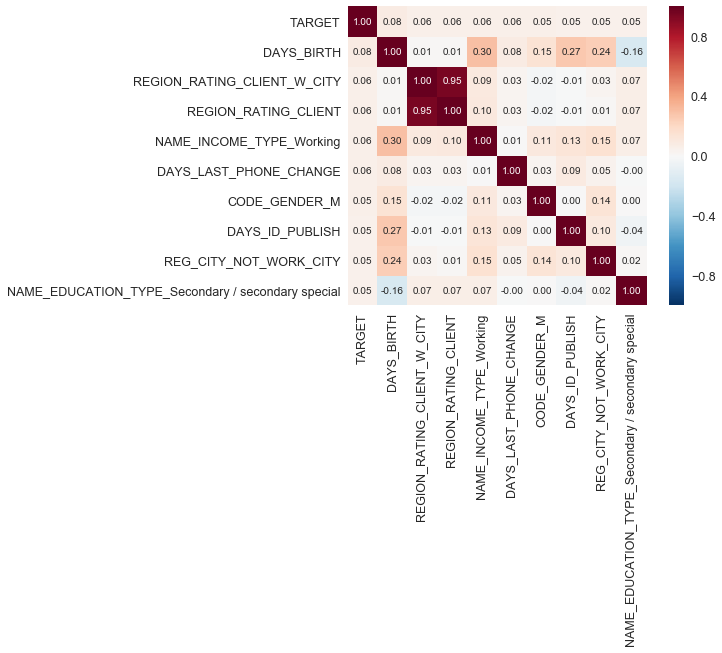

In [160]:
#Show a Zoom HEAT MAPPING
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'TARGET')['TARGET'].index
cm = np.corrcoef(train_wo_nan_encoded[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### どの値が大切かを教えてもらいましょう。
現在、182の特徴量があります。
何も考えずに全てをモデルに投げるのも手ですが、
逆に、モデルにどのFeatureが予測に大切か教えてもらいましょう。今回は、ランダムフォレスト (Regressor)を使います。


In [161]:
#ランダムフォレストは、決定木を応用しており特徴量が多い時に、重要なものをランクすることもできるはずです。
# このあとで学習することも考えファイルを分けておきましょう。
#  その前に今回のデータをy_train, X_trainと分けましょう

# split data for training
y_train = train_wo_nan_encoded['TARGET']
X_train = train_wo_nan_encoded.drop('TARGET', axis=1)
y_train.shape, X_train.shape

((307511,), (307511, 184))

In [162]:
X_train


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0,100002,0,0,1,0,202500.000,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,1,100003,0,0,0,0,270000.000,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,2,100004,1,1,1,0,67500.000,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,3,100006,0,0,1,0,135000.000,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,4,100007,0,0,1,0,121500.000,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
5,5,100008,0,0,1,0,99000.000,490495.5,27517.5,454500.0,...,0,0,0,0,0,0,0,0,0,0
6,6,100009,0,1,1,1,171000.000,1560726.0,41301.0,1395000.0,...,0,0,0,0,0,0,0,0,0,0
7,7,100010,0,1,1,0,360000.000,1530000.0,42075.0,1530000.0,...,0,0,0,0,0,0,0,0,0,0
8,8,100011,0,0,1,0,112500.000,1019610.0,33826.5,913500.0,...,0,0,0,0,0,0,0,0,0,1
9,9,100012,1,0,1,0,135000.000,405000.0,20250.0,405000.0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
y_train

0         1
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        1
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        0
35        0
36        0
37        0
38        0
39        0
40        1
41        0
42        1
43        0
44        0
45        0
46        0
47        0
48        0
49        0
50        0
51        0
52        0
53        0
54        0
55        0
56        0
57        0
58        0
59        0
60        0
61        0
62        0
63        0
64        0
65        0
66        0
67        0
68        0
69        0
70        0
71        0
72        0
73        0
74        0
75        0
76        0
77        0
78        0
79        0
80        0
81        1
82        0
83  

In [168]:
#ランダムフォレスト 
# feature importance using random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, max_features='auto')
rf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Training done using Random Forest


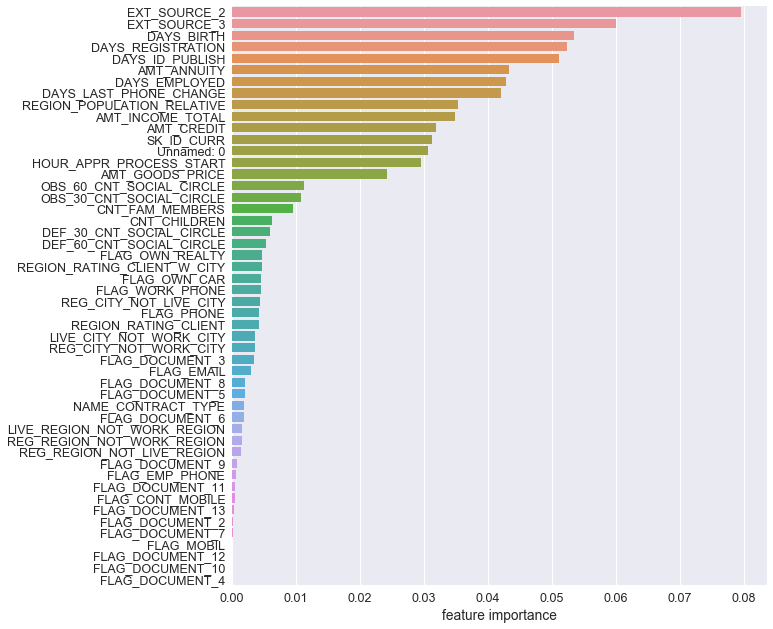

In [169]:
#5０で出す
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_[:50])
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking][:50], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

### 重要な説明変数と目的変数との関係を目で見ましょう

In [175]:
# use the top 30 features only
X_train_ranked = X_train.iloc[:,ranking[:30]]
#X_test_ranked = X_test.iloc[:,ranking[:30]]

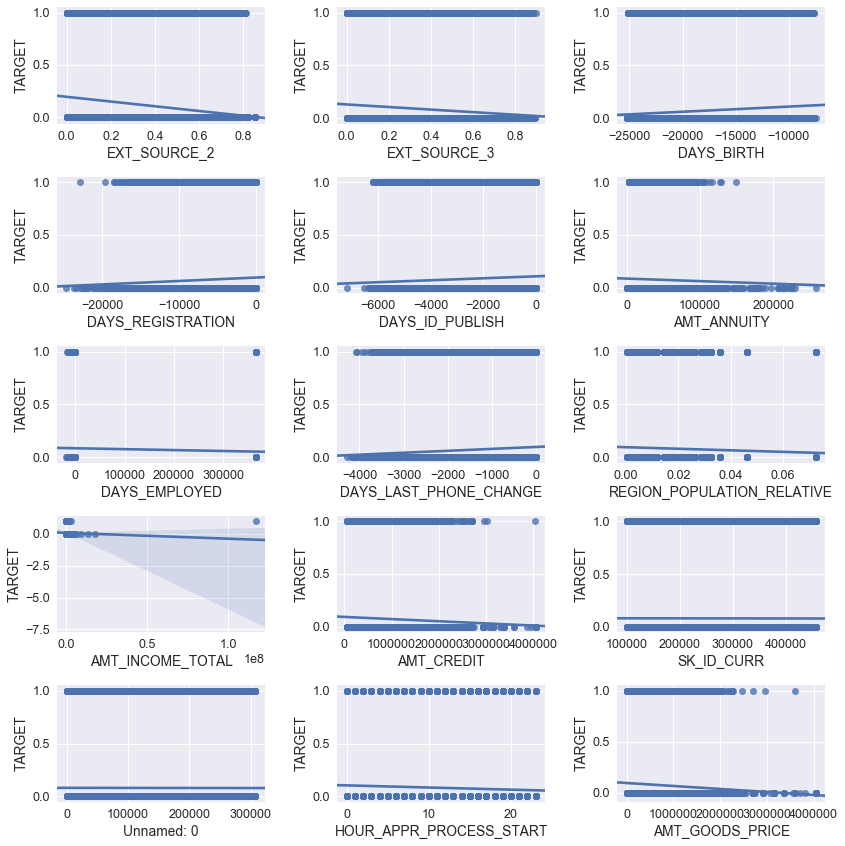

In [176]:
# relation to the target
fig = plt.figure(figsize=(12,12))
for i in np.arange(15):
    ax = fig.add_subplot(5,3,i+1)
    sns.regplot(x=X_train_ranked.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

ここまでの段階で、TARGETを明確に説明できそうな強い変数が見つかったとはえません。TrainCSVの中には関係する変数がなかったということだとも言えるため、ここからはこのCSVにさらに特徴量を増やしたいと考える方が良いかと考えます。しかし、与えられているデータからまずは学習と検証はできるので、以下に、この段階での学習と検証を行います。

# 学習

## test ファイルを作成

In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1)

In [183]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276759 entries, 79493 to 163572
Columns: 184 entries, Unnamed: 0 to ORGANIZATION_TYPE_XNA
dtypes: float64(20), int64(164)
memory usage: 390.6 MB


In [184]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30752 entries, 107435 to 218391
Columns: 184 entries, Unnamed: 0 to ORGANIZATION_TYPE_XNA
dtypes: float64(20), int64(164)
memory usage: 43.4 MB


In [187]:
y_train.head()

79493     0
292954    0
86734     0
274689    1
86206     0
Name: TARGET, dtype: int64

In [191]:
y_test.head(15)

107435    0
12496     0
303424    0
101087    0
164385    0
262070    0
271863    0
138214    0
24427     0
7837      0
273679    0
259003    0
235854    0
205024    1
58862     0
Name: TARGET, dtype: int64

###  ロジスティクス回帰 (Benchmark)

In [236]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000) 
lr.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [237]:
# X_testを使って予測する
lr_pred = lr.predict(X_test)

In [216]:
pd.Series(reg_lr).unique()

array([0, 1])

In [238]:

lr.score(X_test, y_test)

0.92059053069719043

In [259]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, lr_pred)

0.49998233902016886

### サポートベクターマシン

In [241]:
from sklearn import svm
#Standard = svm.LinearSVC(C=1.0, intercept_scaling=1, multi_class=False , loss="l1", penalty="l2", dual=True)
svm = svm.LinearSVC()
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

In [233]:

svm.score(X_test, y_test)


0.81591441207075965

In [260]:
roc_auc_score(y_test, svm_pred)

0.5

### Gradient Boosting Classifier

In [239]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# 学習データ
#train_data = np.loadtxt('CodeIQ_auth.txt', delimiter=' ')
#X_train = [[x[0], x[1]] for x in train_data]
#y_train = [int(x[2]) for x in train_data]

# 試験データ
#X_test = np.loadtxt('CodeIQ_mycoins.txt', delimiter=' ')
#y_test = np.array([1,0,0,1,1,0,1,1,1,0,0,1,1,0,0,1,0,0,0,1])

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
        max_depth=1).fit(X_train, y_train)

gbc_pred = gbc.predict(X_test)
#Print("Predict ",gbc.predict(X_test))
#print ("Expected", y_test)
#print gbc.score(X_test, y_test)


In [240]:
gbc.score(X_test, y_test)

0.92062304890738811

In [261]:
roc_auc_score(y_test, gbc_pred)

0.5

### (のちにやります)XG Boost

In [ ]:
# XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# xgboostモデルの作成
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_cv = GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_cv.fit(X_train, y_train)
print(clf_cv.best_params_, clf_cv.best_score_)

# 改めて最適パラメータで学習
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(X_train, y_train)



### (のちにやります)Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
nn = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
nn.fit(X_train, y_train)

## （のちにやります）比較

In [253]:
# second training matrix
X_train2 = pd.DataFrame( {'LR': lr,
     'SVM': svm,
     'GBC': gbc,
    })
pd.set_option("display.max_rows", 10000)
print(X_train2)

# X_train2 = pd.DataFrame( {'LR': lr.predict(X_train),
#      'SVM': svm.predict(X_train),
#      'GBC': gbc.predict(X_train),
#      'XGB': clf.predict(X_train),
#      'NN': nn.predict(X_train).ravel(),
#     })

                                                                                                     GBC  \
0   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
1   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
2   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
3   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
4   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
5   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
6   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
7   [DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,\n           max_features=None, max_...   
8   [DecisionTreeRegressor(c

###   （のちにやります）アンサンブル学習
多くの場合、アンサンブル (Emsemble)といって、複数のモデルの予測結果を平均した方がより良い予測に繋がる場合が多いということです。

今回はLogistics回帰、サポートベクトルマシン、Gradient Boosting Classifire, XGBoost、Neural Networkのモデルを別々に訓練し、結果を平均して出したいと思います。

最も単純な線形モデルを使って、各モデルの重みを決定し、最終的な全体の予測値を計算する。

最後に、ターゲットをlogにしていたので、expを使って元のスケールに戻すことを忘れないようにする。

In [ ]:
# test data modeling using linear regression
#from sklearn import linear_model

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# second training matrix
X_train2 = pd.DataFrame( {'LR': lr,
     'SVM': svm,
     'GBC': gbc,
    })

#prediction using the test set
X_test2 = pd.DataFrame( {'LR': lr_pred,
    'SVM': svm_pred,
    'GBC': gbc_pred,
   })

#voting='hard'に設定し、単純な多数決で値を決めることにする。
eclf = VotingClassifier(estimators=[('lr', lr_pred), ('svm', svm_pred), ('gbc', gbc_pred)], voting='hard')


for clf, label in zip([lr, svm, gbc, eclf], ['Logistic Regression', 'Support Vector Machine', 'Gradient Boosting Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


    
#reg = VotingClassifier.VotingClassifier()
#reg.fit(X_train2, y_train)

# prediction using the test set
#X_test2 = pd.DataFrame( {'LR': lr_pred,
#     'SVM': svm_pred,
#     'GBC': gbc_pred,
#    })



# X_test2 = pd.DataFrame( {'LR': lr.predict(X_test),
#      'SVM': svm.predict(X_test),
#      'GBC': gbc.predict(X_test),
#      'XGB': clf.predict(X_test),
#      'NN': nn.predict(X_test).ravel(),
#     })

## Don't forget to convert the prediction back to non-log scale
#y_pred = np.exp(reg.predict(X_test2))

## submission
#submission = pd.DataFrame({
#    "SK_ID_CURR": SK_ID_CURR,
#    "TARGET": y_pred
#})
#submission.to_csv('summissionshitai.csv', index=False)


In [ ]:
roc_auc_score(y_test, eclf)

# 検証方法
各機械学習モデルを用いて、精度を検証した。
７月２８日時点の３モデルの比較が０.５となっており、正直ROC曲線の閾値の値になっていることから、何も結果が出ていないことになる。つまりここではさらに特徴量を増やさないといけないことがわかった。




# 残された課題・議論は？
- 特徴量を増やすことが必要であると考える
- ハイパーパラメータの調整で精度が向上する可能性がある。そこの部分がまだよくわかっていないので、今週の学習テーマの一つとする。
- 欠損値はいじったが、外れ値の研究を全く行っていないので、そこも余地がある。
- クレジットカードからの情報など、他に活用できそうなcsvファイルを全く活用していないので、そこも余地がある。
- 欠損値のなかでかなり落としたものもあるので、考慮できる余地がある。

# (のちにやります)Graph


In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 2)
auc = metrics.roc_auc_score(y_test, lr, svm, gbc, clf, nn)
auc

reg_lr = lr.predict(X_test), svm.predict(X_test), gbc.predict(X_test), clf.predict(X_test), nn.predict(X_test)

#metrics.auc(fpr, tpf)

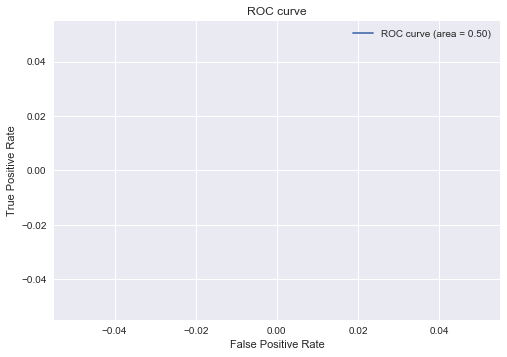

In [148]:
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)